<a href="https://colab.research.google.com/github/Nebyx/fcc_ML_notebooks/blob/main/Book%20Recommendation%20Engine%20using%20KNN/fcc_book_recommendation_knn_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Book Recommendation Engine using K-Nearest Neighbors (KNN)**


---


The goal of this project is to build a book recommendation engine using K-Nearest Neighbors (KNN) algorithm. This recommendation system suggests similar books to users based on their interactions with other books.


---

This project is part of the Machine Learning with Python course from [freeCodeCamp](https://www.freecodecamp.org/).

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## **Data Source**
The project uses data from the Book-Crossings dataset, which contains information about books and user ratings.

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2023-08-29 16:57:13--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.1’

book-crossings.zip. 100%[===================>]  24.88M  99.7MB/s    in 0.2s    

2023-08-29 16:57:13 (99.7 MB/s) - ‘book-crossings.zip.1’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


## **Data Preprocessing**
---
Books with less than 100 ratings and users with less than 200 ratings are removed. A user/rating sparse matrix is created to represent book ratings.

In [ ]:
# Count the number of ratings for each book
book_counts = df_ratings['isbn'].value_counts()
# Select books with at least 100 ratings
popular_books = df_books[df_books['isbn'].isin(book_counts[book_counts >= 100].index)]
popular_books

,isbn,title,author
18,0440234743,The Testament,John Grisham
19,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison
26,0971880107,Wild Animus,Rich Shapero
27,0345402871,Airframe,Michael Crichton
28,0345417623,Timeline,MICHAEL CRICHTON
...,...,...,...
28072,0425178765,Easy Prey,John Sandford
29215,0449223604,M Is for Malice,Sue Grafton
30535,0345444884,The Talisman,STEPHEN KING
30775,0060008032,Angels,Marian Keyes


In [ ]:
# Count the number of ratings for each user
user_counts = df_ratings['user'].value_counts()
# Select users with at least 200 ratings
active_users = df_ratings[df_ratings['user'].isin(user_counts[user_counts >= 200].index)]
active_users

,user,isbn,rating
1456,277427,002542730X,10.0
1457,277427,0026217457,0.0
1458,277427,003008685X,8.0
1459,277427,0030615321,0.0
1460,277427,0060002050,0.0
...,...,...,...
1147612,275970,3829021860,0.0
1147613,275970,4770019572,0.0
1147614,275970,896086097,0.0
1147615,275970,9626340762,8.0


In [ ]:
# Filter ratings to include only active users and popular books
filtered_ratings = df_ratings[
    df_ratings['user'].isin(active_users['user']) & df_ratings['isbn'].isin(popular_books['isbn'])
    ]

# Create a pivot table to represent user ratings for books
pivot_book = filtered_ratings.pivot_table(
    index='isbn', columns='user', values='rating', fill_value=0
    )

# Create a sparse matrix representation of user ratings for collaborative filtering
sparse_book_ratings = csr_matrix(pivot_book)


In [ ]:
# Display the user/rating sparse matrix
pivot_book

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,
002542730X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,0
0060008032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0060096195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
006016848X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0060173289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573227331,0,0,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1573229326,0,0,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1573229571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Building the Model**
---
A K-Nearest Neighbors (KNN) model is trained using the NearestNeighbors class from sklearn, considering cosine similarity.

In [ ]:
# Instantiate the NearestNeighbors model with cosine distance metric
model = NearestNeighbors(metric='cosine')

# Fit the model to the user/rating sparse matrix
model.fit(sparse_book_ratings)

NearestNeighbors(metric='cosine')

## **Generating Recommendations**
---
The function `get_recommends(book)` provides book recommendations for a given title using the KNN model. It returns recommended books and their similarity scores.

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  try :
    # Find the details of the requested book
    requested_book=popular_books[popular_books["title"] == book]
  except KeyError as e:
    # Handle the case where the requested book doesn't exist
    print('Book', e, 'does not exist')
    return

  # Get the ratings for the requested book from the pivot table
  requested_book_ratings = pivot_book[pivot_book.index.isin(requested_book["isbn"])]
  # Find the nearest neighbors and their distances using the model
  distance, indices = model.kneighbors([requested_book_ratings.values[0]], n_neighbors=6)

  recommendations=[]
  # Iterate through theindices of nearest neighbors
  for i in indices[0][1:]:
    # Find and append the titles of recommended books
    recommendations.append(popular_books[popular_books['isbn']==pivot_book.iloc[i].name]["title"].values[0])

  # Combine recommended books and their similarity scores
  recommended_books = [list(z) for z in zip(recommendations, distance[0][1:])][::-1]

  return [book,recommended_books]

In [ ]:
# Get recommendations for a specific book
get_recommends('The Queen of the Damned (Vampire Chronicles (Paperback))')

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835419270879],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448657003312193],
  ['Interview with the Vampire', 0.7345068863988313],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))',
   0.5376338446489461],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178411864186413]]]

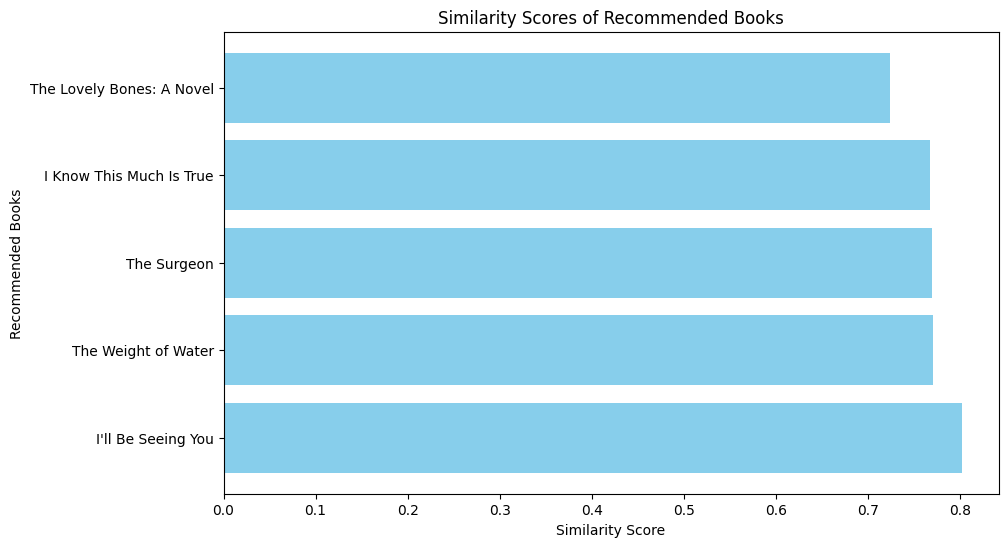

In [ ]:
# Get recommended books and their similarity scores
recommended_books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")[1]
recommended_titles = [book[0] for book in recommended_books]
similarity_scores = [book[1] for book in recommended_books]

# Create a bar plot to visualize similarity scores
plt.figure(figsize=(10, 6))
plt.barh(recommended_titles, similarity_scores, color='skyblue')
plt.xlabel('Similarity Score')
plt.ylabel('Recommended Books')
plt.title('Similarity Scores of Recommended Books')
plt.show()


In [ ]:
# Display the list of recommended books and their similarity scores
print(recommended_books)

[["I'll Be Seeing You", 0.8016210581447822], ['The Weight of Water', 0.7708583572697412], ['The Surgeon', 0.7699410973804288], ['I Know This Much Is True', 0.7677075092617776], ['The Lovely Bones: A Novel', 0.7234864549790632]]


In [ ]:

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

You passed the challenge! 🎉🎉🎉🎉🎉
